In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd  
import csv
from scipy.io import savemat
from scipy.io import loadmat
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from functools import reduce 
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import random
from scipy.stats import ttest_ind, ttest_rel #, permutation_test
from scipy.stats import ttest_1samp
from statsmodels.stats import multitest
from itertools import combinations
from itertools import permutations
from numpy.linalg import inv
from brainiak.utils import utils
from brainiak.funcalign import srm
import brainiak

## Load Dataset

Download data from https://zenodo.org/records/14730569

In [2]:
cv=10
srm_k=[5]

In [3]:
pickle_file = open("./all_data.pkl", "rb")
objects = []

i=0

while True:
   
    try:

        objects.append(pickle.load(pickle_file))

    except EOFError:

        break

pickle_file.close()

a=objects[0]

In [4]:
Y_data=a['electrode_data']
elec_num=a['electrode_number'] 
word_embeddings=a['word_embeddings'] 
lags=a['lags']
subjects=np.arange(1, np.shape(Y_data)[0]+1)

In [6]:
print(np.shape(Y_data))
print(np.shape(word_embeddings))

(8, 161, 5013, 43)
(5013, 1600)


In [7]:
pca = PCA(n_components=50)
word_embeddings2=word_embeddings- np.mean(word_embeddings, axis=0)
word_embeddings=pca.fit_transform(word_embeddings2)
word_embeddings = normalize(word_embeddings, axis=1, norm='l2')

## functions for Plotting

In [5]:
def fdr(pvals):
    _, pcor, _, _ = multitest.multipletests(
        pvals, method="fdr_bh", is_sorted=False
    )
    return pcor

def get_sig_lags1( lags, a,b, threshold=0.01):
    #sig_lags = {}
    
    # df_prob = a#df_key[df_key.index.get_level_values("label") == label1]
    # df_improb =b# df_key[df_key.index.get_level_values("label") == label2]
    # df_prob.sort_values([("electrode")], ascending=True, inplace=True)
    # df_improb.sort_values([("electrode")], ascending=True, inplace=True)

    ts = []
    rs = []
    for df_col in np.arange(0,a.shape[1]):
        # r = ttest_ind(a[:,df_col], b[:,df_col],alternative="two-sided")
        r = ttest_rel(a[:,df_col], b[:,df_col],alternative="two-sided") #ttest_rel
        ts.append(r[0])
        rs.append(r[1])
    rs = fdr(rs)

    # threshold = 0.05
    sig_lags = [lags[idx] for (idx, r) in enumerate(rs) if ( ts[idx] > 0 and  r < threshold)]
    #sig_lags[f"{key}_{label2}"] = [lags[idx] for (idx, r) in enumerate(rs) if (ts[idx] < 0 and r < threshold)]
    
    return sig_lags


def plot_data_prep(a):
    
    mu=np.mean(a,axis=0)
    
    q=np.std(a, axis=0)

    err=q/np.sqrt(np.shape(a)[0])
    
    a1=mu-err
    a2=mu+err
    
    return a1,a2,mu

## Encoding with original neural data

In [ ]:
def computing_regression_cv(data1, word_embeddings,elec_num,cv):
    
    lag=np.shape(data1)[0]
    
    final_corr=np.zeros((cv,lag))
    
    kf = KFold(n_splits=cv)
    p=0
    
    for train_index, test_index in kf.split(word_embeddings):
        
        corr_lin2=[]
        
        X_train,X_test = word_embeddings[train_index,:],word_embeddings[test_index,:]
    
        X_train -= np.mean(X_train, axis=0)
        X_test -= np.mean(X_train, axis=0)
        
        for i in range(lag):
            
            corr_lin1=[]
            
            data=data1[i,:,:]
            data=data[:,:elec_num]
        
            for k in range(np.shape(data)[1]):
                
                label=data[:,k]  
                Y_train,Y_test = label[train_index],label[test_index]
                
       
                Y_train -= np.mean(Y_train, axis=0)
                Y_test -= np.mean(Y_train, axis=0)
              
                
                
                #We fit the Linear regression to our train set
                clf_linear=LinearRegression()
                clf_linear.fit(X_train,Y_train)
                
                
                prediction_linear=clf_linear.predict(X_test)
                
                corr_lin1.append(np.corrcoef(Y_test,prediction_linear)[0,1])
                
                del clf_linear
                
            corr_lin2.append(np.mean(corr_lin1))
            
        final_corr[p,:]=np.asarray(corr_lin2)
        p=p+1
            
    return final_corr

In [ ]:
corr_original=[]
print('Computing original Encoding')

for qq in range(len(subjects)):
    
    corr_original.append(computing_regression_cv(Y_data[qq,:,:,:], word_embeddings, elec_num[qq],cv))

In [8]:
#plot
filename2='/scratch/gpfs/arnab/Encoding/plot_mat_files/result_all_sub_compute_regression.mat'
lags=np.squeeze(loadmat(filename2)['lags'])
corr_original=np.squeeze(loadmat(filename2)['corr_original'])
original_regression=np.zeros((len(subjects),3,len(lags)))

for qq in range(len(subjects)):
    
    aa=corr_original[qq,:,:]    
    [a1,a2,mu]=plot_data_prep(aa)
    
    original_regression[qq,0,:]=a1
    original_regression[qq,1,:]=a2
    original_regression[qq,2,:]=mu
    
    del aa

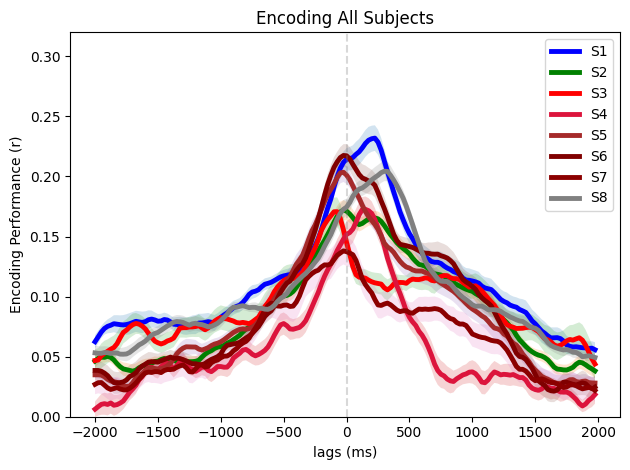

In [9]:
color=['blue','green','red','crimson','brown','maroon','darkred','gray']
for qq in range(len(subjects)):
    
    a=corr_original[qq,:,:]

    plt.fill_between(lags, original_regression[qq,0,:], original_regression[qq,1,:], alpha=0.2)
    plt.plot(lags, original_regression[qq,2,:], linewidth=3.5, label = 'S'+str(qq+1), color=color[qq]) #"original")  #, color=c1, ls=ls, lw = lw)

plt.ylim(0, 0.32)
plt.xlabel('lags (ms)')
plt.ylabel('Encoding Performance (r)')
plt.title('Encoding All Subjects')
plt.tight_layout()
plt.axvline(0, ls="dashed", alpha=0.3, c="grey")
plt.legend()

## Encoding in the Shared Space

In [ ]:
def srm_regression_cv(Y_data,word,elec_num,features,cv):
    
    
    lag=np.shape(Y_data)[1]
    n_iter = 100
    final_corr=np.zeros((cv,lag))
    final_corr_all_features=np.zeros((cv,lag,features))

    kf = KFold(n_splits=cv)
    p=0
    
    for train_index, test_index in kf.split(word):
        corr_srm=[]
    
        for i in range(lag):
            
            train_data=[]
            test_data=[]
            
            for qq in range(len(subjects)):
                
                data=Y_data[qq,i,:,:]
                data=data[:,:elec_num[qq]]
                
                
                train1=data[train_index,:].T
                test1=data[test_index,:].T
                
                train_data.append(train1)
                test_data.append(test1)
            
            
              # How many iterations of fitting will you perform
        
            # Create the SRM object
            srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)
            
            srm.fit(train_data)
            
            shared_test = srm.transform(test_data)
            shared_train = srm.transform(train_data)
            
            s_avg_train=shared_train[0]
            s_avg_test=shared_test[0]
            for ii in range(1,len(subjects)):
                s_avg_train=s_avg_train+shared_train[ii]
                s_avg_test=s_avg_test+shared_test[ii]

            s_avg_train=s_avg_train/len(subjects)
            s_avg_test=s_avg_test/len(subjects)

            X_train= word[train_index,:]
            X_test= word[test_index,:]
            
            X_train -= np.mean(X_train, axis=0)
            X_test -= np.mean(X_train, axis=0)
            
            srm_train=s_avg_train.T
            srm_test=s_avg_test.T
            
            c=[]       
            for k in range(features):               
                
                Y_train=srm_train[:,k]
                Y_test=srm_test[:,k]
                
                Y_train -= np.mean(Y_train, axis=0)
                Y_test -= np.mean(Y_train, axis=0)
                
                clf_linear=LinearRegression()
                clf_linear.fit(X_train,Y_train)
                prediction_linear=clf_linear.predict(X_test)

                                
                c.append(np.corrcoef(Y_test,prediction_linear)[0,1])
                del clf_linear
            # print(np.mean(c))    
            corr_srm.append(np.mean(c))
            final_corr_all_features[p,i,:]=c 
            
        final_corr[p,:]=corr_srm
        p=p+1
            
    return final_corr,final_corr_all_features

In [ ]:
print('Compute shared space regression')
srm_corr_cv=np.zeros((len(srm_k),cv,len(lags)))
for k in range(len(srm_k)):

    srm_corr_cv[k,:,:], shared_space_all_features = srm_regression_cv(Y_data,word_embeddings,elec_num,srm_k[k],cv)

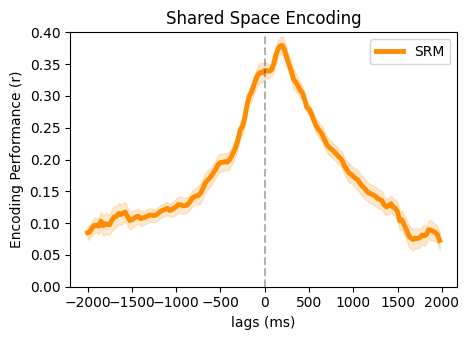

In [11]:
#plotting
filename14='/scratch/gpfs/arnab/Encoding/plot_mat_files/shared_space_regression_new.mat'
shared_space_regression1=np.squeeze(loadmat(filename14)['srm_shared_corr_cv'])
lags=np.squeeze(loadmat(filename14)['lags'])

shared_space_regression=np.zeros((3,len(lags)))
[a1,a2,mu]=plot_data_prep(shared_space_regression1)
shared_space_regression[0,:]=a1
shared_space_regression[1,:]=a2
shared_space_regression[2,:]=mu

plt.figure(figsize=(4.8,3.5))

plt.fill_between(lags, shared_space_regression[0,:], shared_space_regression[1,:], alpha=0.2, color='darkorange')
plt.plot(lags, shared_space_regression[2,:], linewidth=3.5, label = "SRM", color='darkorange')  #, color=c1, ls=ls, lw = lw)
plt.axvline(0, ls="dashed", alpha=0.3, c="k")
plt.ylim([0,0.4])
name='Shared Space Encoding'

plt.legend()
plt.xlabel('lags (ms)')
plt.ylabel('Encoding Performance (r)')
plt.title(name)
plt.tight_layout()

## Encoding with PCA reduced Neural data

In [ ]:
def pca_data_prep(data1,train_index,test_index,value):
    
    a1=data1[train_index,:] 
    b1=data1[test_index,:]
    a1=a1-(np.mean(a1,axis=0))
    b1=b1-(np.mean(a1,axis=0))
   
    
    pca = PCA(n_components=value)

    train_717_pca = pca.fit_transform(a1)
    test_717_pca = pca.transform(b1)
    
    return train_717_pca,test_717_pca

In [ ]:
def pca_across_subject(Y_data, word_embeddings,cv=10,value=5):
    
    lag=np.shape(Y_data)[1]
    
    final_corr=np.zeros((cv,lag))
    
    kf = KFold(n_splits=cv)
    p=0
    
    for train_index, test_index in kf.split(word_embeddings):
        
        corr_lin2=[]
        
        X_train,X_test = word_embeddings[train_index,:],word_embeddings[test_index,:]
    
        # X_train= word_embeddings[0:4000,:]  #working on the last fold
        # X_test= word_embeddings[4000:5013,:]
    
        X_train -= np.mean(X_train, axis=0)
        X_test -= np.mean(X_train, axis=0)
        
        for i in range(lag):
            
            corr_lin1=[]
            # a1,b1=pca_data_prep(Y_data[0,i,:,:elec_num[0]],train_index,test_index,value)
            a1=Y_data[0,i,:,:elec_num[0]]
            data_train1=a1[train_index,:]
            data_test1=a1[test_index,:]


            for qq in range(1,len(subjects)):
                del a1
                # a11,b11=pca_data_prep(Y_data[qq,i,:,:elec_num[qq]],train_index,test_index,value)
                a1=Y_data[qq,i,:,:elec_num[qq]]
                temp_train=a1[train_index,:]
                temp_test=a1[test_index,:]
                
                data_train1=np.concatenate((data_train1,temp_train),axis=1)
                data_test1=np.concatenate((data_test1,temp_test),axis=1)

            data_train1=data_train1-(np.mean(data_train1,axis=0))
            data_test1=data_test1-(np.mean(data_train1,axis=0))

            pca = PCA(n_components=value)

            data_train = pca.fit_transform(data_train1)
            data_test = pca.transform(data_test1)

            #data=data1[i,:,:]
            # [data_train,data_test]=pca_data_prep(data1[i,:,:],data2[i,:,:],data3[i,:,:],train_index,test_index,value)
        
            for k in range(np.shape(data_train)[1]):
                
                Y_train=data_train[:,k]  
                Y_test=data_test[:,k]  
                #Y_train,Y_test = label[train_index],label[test_index]
                
                # Y_train=data[0:4000,k]  
                # Y_test=data[4000:5013,k]
                
                Y_train -= np.mean(Y_train, axis=0)
                Y_test -= np.mean(Y_train, axis=0)
              
                
                
                #We fit the Linear regression to our train set
                clf_linear=LinearRegression()
                clf_linear.fit(X_train,Y_train)
                
                
                prediction_linear=clf_linear.predict(X_test)
                
                corr_lin1.append(np.corrcoef(Y_test,prediction_linear)[0,1])
                
                del clf_linear
                
            corr_lin2.append(np.mean(corr_lin1))
            
        final_corr[p,:]=np.asarray(corr_lin2)
        p=p+1
            
    return final_corr

In [ ]:
print('PCA regression')

pca_across_sub=pca_across_subject(Y_data, word_embeddings,cv=10,value=5)

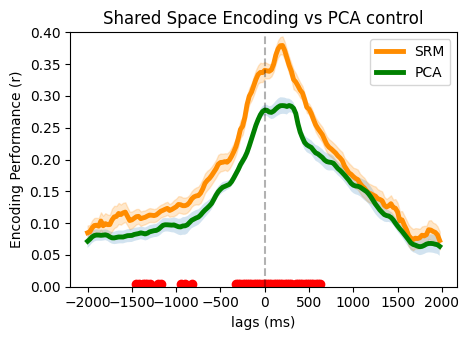

In [18]:
#plot

#plotting
filename14='/scratch/gpfs/arnab/Encoding/plot_mat_files/shared_space_regression_new.mat'
filename24='/scratch/gpfs/arnab/Encoding/plot_mat_files/pca_across_subject.mat'

shared_space_regression1=np.squeeze(loadmat(filename14)['srm_shared_corr_cv'])
lags=np.squeeze(loadmat(filename14)['lags'])

pca_across_sub1=np.squeeze(loadmat(filename24)['pca_across_subject'])

shared_space_regression=np.zeros((3,len(lags)))
pca_across_sub=np.zeros((3,len(lags)))

[a1,a2,mu]=plot_data_prep(shared_space_regression1)
shared_space_regression[0,:]=a1
shared_space_regression[1,:]=a2
shared_space_regression[2,:]=mu

[a1,a2,mu]=plot_data_prep(pca_across_sub1)
pca_across_sub[0,:]=a1
pca_across_sub[1,:]=a2
pca_across_sub[2,:]=mu

plt.figure(figsize=(4.8,3.5))

plt.fill_between(lags, shared_space_regression[0,:], shared_space_regression[1,:], alpha=0.2, color='darkorange')
plt.plot(lags, shared_space_regression[2,:], linewidth=3.5, label = "SRM", color='darkorange')  #, color=c1, ls=ls, lw = lw)

plt.fill_between(lags, pca_across_sub[0,:], pca_across_sub[1,:], alpha=0.2)
plt.plot(lags, pca_across_sub[2,:], linewidth=3.5, label = "PCA", color='green')  #, color=c1, ls=ls, lw = lw)

w=get_sig_lags1( lags, shared_space_regression1,pca_across_sub1)
plt.scatter(w, # (x)
                np.full(len(w), 0.005), # (y)
                color='red')
plt.axvline(0, ls="dashed", alpha=0.3, c="k")
plt.ylim([0,0.4])

name='Shared Space Encoding vs PCA control'

plt.legend()
plt.xlabel('lags (ms)')
plt.ylabel('Encoding Performance (r)')
plt.title(name)
plt.tight_layout()


## Reconstructing Electrode Activity via the Shared Space and doing Encoding

In [ ]:
def encoding_with_augmentation(Y_data, word,elec_num, train_index,test_index):
    
    X_train= word[train_index,:]
    X_test= word[test_index,:]
    
    X=X_train
    X -= np.mean(X, axis=0)
    X_test2 =X_test- np.mean(X, axis=0)
    
    lag=np.shape(Y_data)[1]
    n_iter = 100
    
    final_corr=[]
    for i in range(lag):
        
        train_data=[]
        test_data=[]
        
        for qq in range(len(subjects)):
            
            data=Y_data[qq,i,:,:]
            data=data[:,:elec_num[qq]]
            
            
            train1=data[train_index,:].T
            test1=data[test_index,:].T
            
            train_data.append(train1)
            test_data.append(test1)
    
       
        
        srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=5)
        
        srm.fit(train_data)
        
        shared_test = srm.transform(test_data)
        shared_train = srm.transform(train_data)
        
                
        corr_with_subjects=[]
        
        for qq in range(len(subjects)):

            #print('subject:',subjects[qq])
            
            w0=srm.w_[qq]
            
            subject_elec=elec_num[qq]
            
            self_train=w0.dot(shared_train[qq])
            Y_train=self_train.T
            self_test=w0.dot(shared_test[qq])
            Y_test=self_test.T

            corr1_with_717=[]
            for k in range(subject_elec):
                
                Y=Y_train[:,k]

                Y -= np.mean(Y, axis=0)
                Y_test2 =Y_test[:,k]- np.mean(Y, axis=0)
                
                                
                clf_linear2=LinearRegression()
                clf_linear2.fit(X,Y)
                prediction_linear2=clf_linear2.predict(X_test2)
                corr1_with_717.append(np.corrcoef(Y_test2,prediction_linear2)[0,1])
                del clf_linear2
                
                
            corr_with_subjects.append(np.mean(corr1_with_717))

            del Y_train
            del Y_test
            
        ww=np.array(corr_with_subjects)
        
        final_corr.append(ww)        
    return final_corr

In [ ]:
kf = KFold(n_splits=cv)
p=0
corr_with_subjects=np.zeros((cv,len(lags),len(subjects)))

for train_index, test_index in kf.split(word_embeddings):

        print('Fold:',p)
        
        corr_with_subjects[p,:,:]=encoding_with_augmentation(Y_data,word_embeddings,elec_num, train_index, test_index)
    
        p=p+1

In [19]:
#plot
filename2='/scratch/gpfs/arnab/Encoding/plot_mat_files/result_all_sub_compute_regression.mat'
filename5='/scratch/gpfs/arnab/Encoding/plot_mat_files/srm_result_all_sub_without_augmentation_cv_10.mat'
lags=np.squeeze(loadmat(filename2)['lags'])

corr_original=np.squeeze(loadmat(filename2)['corr_original'])
corr_with_subjects_no_aug=loadmat(filename5)['corr_with_subjects'] #srm

original_regression=np.zeros((len(subjects),3,len(lags)))
no_aug_srm=np.zeros((len(subjects),3,len(lags)))

for qq in range(len(subjects)):
    
    aa=corr_original[qq,:,:]    
    [a1,a2,mu]=plot_data_prep(aa)
    
    original_regression[qq,0,:]=a1
    original_regression[qq,1,:]=a2
    original_regression[qq,2,:]=mu
    
    del aa

    aa=corr_with_subjects_no_aug[:,:,qq]
    [a1,a2,mu]=plot_data_prep(aa)
    
    no_aug_srm[qq,0,:]=a1
    no_aug_srm[qq,1,:]=a2
    no_aug_srm[qq,2,:]=mu    
    
    del aa

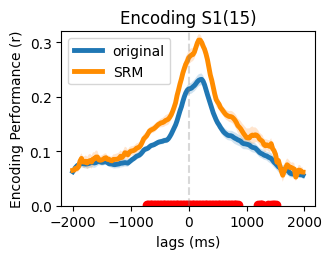

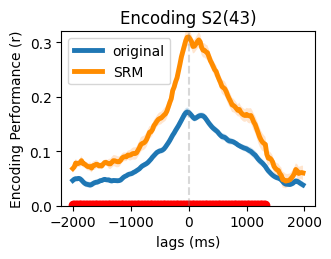

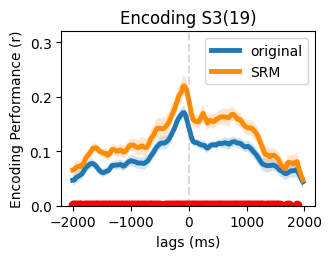

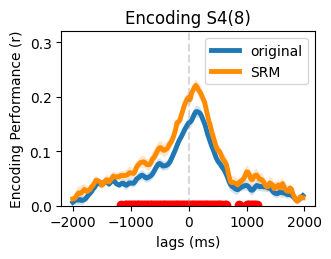

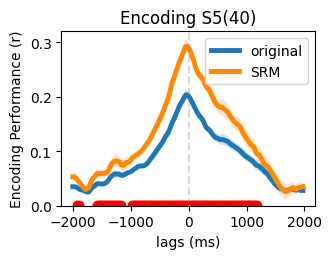

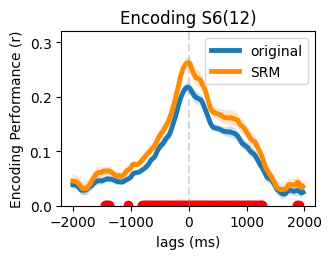

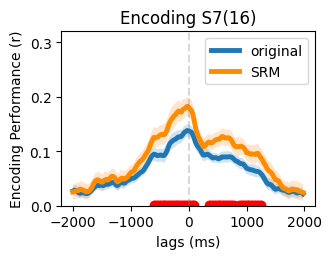

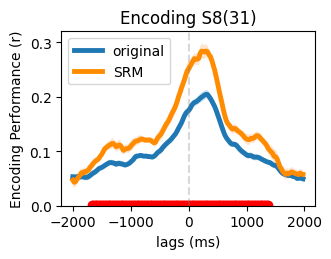

In [22]:
for qq in range(len(subjects)):
    
    a=corr_original[qq,:,:]
    b=corr_with_subjects_no_aug[:,:,qq]
    w=get_sig_lags1( lags, b,a)
    
    plt.figure(figsize=(3.5, 2.7))
    plt.fill_between(lags, original_regression[qq,0,:], original_regression[qq,1,:], alpha=0.2)
    plt.plot(lags, original_regression[qq,2,:], linewidth=3.5, label = "original")  #, color=c1, ls=ls, lw = lw)

    plt.fill_between(lags, no_aug_srm[qq,0,:], no_aug_srm[qq,1,:], alpha=0.2)
    plt.plot(lags, no_aug_srm[qq,2,:], linewidth=3.5,label = "SRM",color='darkorange',)  #, color=c1, ls=ls, lw = lw)

    plt.scatter(w, # (x)
                    np.full(len(w), 0.001), # (y)
                    color='red')
    name='Encoding'+' '+'S'+str(qq+1)+'('+str(elec_num[qq])+')'
    plt.ylim(0, 0.32)
    plt.xlabel('lags (ms)')
    plt.ylabel('Encoding Performance (r)')
    plt.title(name)
    plt.tight_layout()
    plt.axvline(0, ls="dashed", alpha=0.3, c="grey")
    plt.legend()

## SRM Shared Space Generalization

In [ ]:
def srm_generalization(Y_data, word,elec_num, train_index,test_index):

    X_train= word[train_index,:]
    X_test= word[test_index,:]
    # X1=np.tile(X_test,(len(subjects)-1,1))
    #X2=np.tile(X_train,(len(subjects)-1,1))
    #X1=X_test
    #X=np.concatenate((X_train, X2, ), axis=0)
    #X=np.concatenate((X_train, X1, ), axis=0)
    X=X_train
    X -= np.mean(X, axis=0)
    X_test2 =X_test- np.mean(X, axis=0)
    
    lag=np.shape(Y_data)[1]
    n_iter = 100
    
    # corr_with_742=[]
    # corr_with_798=[]
    final_corr=[]
    for i in range(lag):
        
        corr_with_subjects=[]
        
        for qq1 in range(len(subjects)):

            sub_now=subjects[qq1]
            train_data=[]
            test_data=[]
            subject_elec=elec_num[qq1]

            for qq in range(len(subjects)):
    
                if subjects[qq]!=sub_now:

                    data=Y_data[qq,i,:,:]
                    data=data[:,:elec_num[qq]]


                    train1=data[train_index,:].T
                    test1=data[test_index,:].T

                    train_data.append(train1)
                    test_data.append(test1)
                    
                else:
                    data=Y_data[qq,i,:,:]
                    data=data[:,:elec_num[qq]]


                    train1=data[train_index,:].T
                    test1=data[test_index,:].T

                    self_train=train1
                    self_test=test1

            features=5
            srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=5)
            srm.fit(train_data)

            shared_train=srm.transform(train_data)
            shared_test=srm.transform(test_data)

            s_avg_train=shared_train[0]
            s_avg_test=shared_test[0]
            
            for ii in range(1,(len(subjects)-1)):
                s_avg_train=s_avg_train+shared_train[ii]
                s_avg_test=s_avg_test+shared_test[ii]
                

            s_avg_train=s_avg_train/(int(len(subjects)-1))
            s_avg_test=s_avg_test/(int(len(subjects)-1))

            Y_train1=s_avg_train.T
            # Y_train2=s_avg_test.T
            
            # transform_train=[]
            # transform_test=[]
            w_new=srm.transform_subject(self_train)
            # q1=w_new.T.dot(self_train)
            # Y_train=(w_new.dot(q1)).T

            # transform_train=(converted_train1[k])
            # transform_train.append(train_data[k])

            q2=w_new.T.dot(self_test)
            Y_test=q2.T
            # Y_test=(w_new.dot(q2)).T
            # transform_test.append(srm1.w_[k].dot(q2))
            # transform_test.append(self_test)

            corr1_with_717=[]
            for k in range(features):
                
                
                Y1=Y_train1[:,k]
                # Y2=Y_train2[:,k]

                #Y=np.concatenate((Y_train[:,k], Y_aug_train[:,k],), axis=0)
                #Y=np.concatenate((Y_train[:,k], Y_aug_test[:,k],), axis=0)
                
                Y1 -= np.mean(Y1, axis=0)
                # Y2 -= np.mean(Y2, axis=0)
                Y_test1 =Y_test[:,k]- np.mean(Y1, axis=0)
                # Y_test2 =Y_test[:,k]- np.mean(Y2, axis=0)
                
                                
                clf_linear2=LinearRegression()
                clf_linear2.fit(X,Y1)
                prediction_linear2=clf_linear2.predict(X_test2)
                corr1_with_717.append(np.corrcoef(Y_test1,prediction_linear2)[0,1])
                del clf_linear2
                
                
            corr_with_subjects.append(np.mean(corr1_with_717))

            #breakpoint()

            del Y_train1
            del Y_test1
            
        ww=np.array(corr_with_subjects)
            
        final_corr.append(ww)     
    

    return final_corr

In [ ]:
kf = KFold(n_splits=cv)
p=0
corr_generalization=np.zeros((cv,len(lags),len(subjects)))

print('Computing srm generalization') 

for train_index, test_index in kf.split(word_embeddings):

    print('Fold:',p)
    
    corr_generalization[p,:,:]=srm_generalization(Y_data,word_embeddings,elec_num, train_index, test_index)

    p=p+1


In [10]:
filename20='/scratch/gpfs/arnab/Encoding/plot_mat_files/srm_generalization.mat'
srm_generalize1=np.squeeze(loadmat(filename20)['srm_generalization'])
lags=np.squeeze(loadmat(filename20)['lags'])

srm_shared_space_generalization=np.zeros((len(subjects),3,len(lags)))

for qq in range(len(subjects)):
    aa=srm_generalize1[:,:,qq]
    [a1,a2,mu]=plot_data_prep(aa)
    
    srm_shared_space_generalization[qq,0,:]=a1
    srm_shared_space_generalization[qq,1,:]=a2
    srm_shared_space_generalization[qq,2,:]=mu    
    
    del aa

a=np.mean(srm_shared_space_generalization,axis=0)


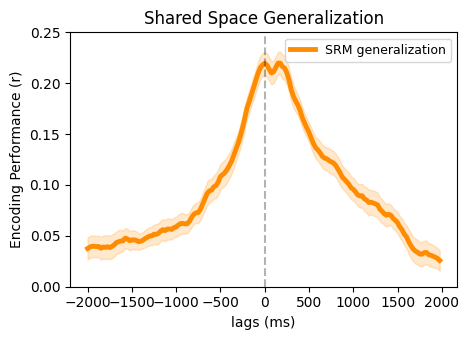

In [11]:
plt.figure(figsize=(4.8,3.5))

plt.fill_between(lags, a[0,:], a[1,:], alpha=0.2, color='darkorange')
plt.plot(lags, a[2,:], linewidth=3.5, label = "SRM generalization", color='darkorange')  #, color=c1, ls=ls, lw = lw)
plt.axvline(0, ls="dashed", alpha=0.3, c="k")


name_t='Shared Space Generalization'

plt.legend( prop={'size':9})
plt.xlabel('lags (ms)')
plt.ylabel('Encoding Performance (r)')
plt.title(name_t)
plt.ylim([0,0.25])
plt.tight_layout()

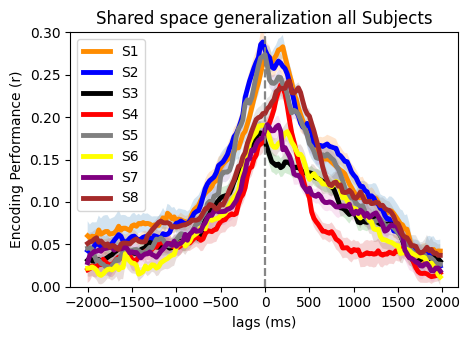

In [25]:
colors=['darkorange','b','k','r','grey','yellow','purple','brown']
plt.figure(figsize=(4.8,3.5))
for qq in range(len(subjects)):

    a1=srm_shared_space_generalization[qq,0,:]
    a2=srm_shared_space_generalization[qq,1,:]
    mu=srm_shared_space_generalization[qq,2,:]
    
    plt.fill_between(lags, a1, a2, alpha=0.2)
    # plt.plot(lags, mu, linewidth=3.5,label = 'Subject= %d' %(subjects[qq]),color=colors[qq],)  #, color=c1, ls=ls, lw = lw)
    plt.plot(lags, mu, linewidth=3.5,label = 'S'+str(qq+1),color=colors[qq],)  #, color=c1, ls=ls, lw = lw)
    plt.ylim([0,0.3])
    plt.xlabel('lags (ms)')
    plt.ylabel('Encoding Performance (r)')
    plt.title('Shared space generalization all Subjects')
    plt.axvline(0, ls="dashed", alpha=0.3, c="grey")
    plt.legend()       
    plt.tight_layout()

plt.savefig('/scratch/gpfs/arnab/Encoding/shared_generalize_all_sub.png',dpi=600)

## pca generalisation across subject

take n-1 subject, do pca and build encoding model, project the left-out subject
and test your encoding model

In [ ]:
def pca_procustes(train,shared_train):

    A=np.matmul(train, (shared_train.T))

    U, S, V = np.linalg.svd(A, full_matrices=False)

    #                 W.append(np.matmul(U,V.T))
    #                 W.append(np.matmul(U,V))
    W=(np.matmul(U,V))
    
    return W



def pca_generalization_across_subject(Y_data, word,elec_num, train_index,test_index):

    X_train= word[train_index,:]
    X_test= word[test_index,:]
   
    X=X_train
    X -= np.mean(X, axis=0)
    X_test2 =X_test- np.mean(X, axis=0)
    
    lag=np.shape(Y_data)[1]
    
    
    # corr_with_742=[]
    # corr_with_798=[]
    final_corr=[]
    for i in range(lag):
        
        corr_with_subjects=[]
        
        for qq1 in range(len(subjects)):

            pw=0

            sub_now=subjects[qq1]
            train_data=[]
            test_data=[]
            subject_elec=elec_num[qq1]

            for qq in range(len(subjects)):
    
                if subjects[qq]!=sub_now:

                    data=Y_data[qq,i,:,:]
                    data=data[:,:elec_num[qq]]


                    temp_train=data[train_index,:]
                    # test1=data[test_index,:]

                    # temp_test=a1[test_index,:]

                    if pw==0:
                        data_train1=temp_train
                        pw=1

                    else:    
                
                        data_train1=np.concatenate((data_train1,temp_train),axis=1)
                    # data_test1=np.concatenate((data_test1,temp_test),axis=1)

                    # train_data.append(train1)
                    # test_data.append(test1)
                    
                else:
                    data=Y_data[qq,i,:,:]
                    data=data[:,:elec_num[qq]]


                    train1=data[train_index,:]
                    test1=data[test_index,:]

                    self_train=train1
                    self_test=test1

            value=5
            pca = PCA(n_components=value)

            Y_train1 = pca.fit_transform(data_train1)
            aaa=np.zeros((np.shape(self_test)[0],np.shape(data_train1)[1]-np.shape(self_test)[1]))
            data_test=np.concatenate((self_test,aaa),axis=1)

            W=pca_procustes(self_train.T,Y_train1.T)

            Y_test=(np.matmul(W.T, self_test.T)).T

            # Y_test = pca.transform(data_test)

            # breakpoint() 

            corr1_with_717=[]
            for k in range(value):
                                
                Y1=Y_train1[:,k]
                
                Y1 -= np.mean(Y1, axis=0)
                Y_test1 =Y_test[:,k]- np.mean(Y1, axis=0)
                
                                
                clf_linear2=LinearRegression()
                clf_linear2.fit(X,Y1)
                prediction_linear2=clf_linear2.predict(X_test2)
                corr1_with_717.append(np.corrcoef(Y_test1,prediction_linear2)[0,1])
                del clf_linear2
                
                
            corr_with_subjects.append(np.mean(corr1_with_717))

            #breakpoint()

            del Y_train1
            del Y_test1
            del data_train1
            del data_test
            
        ww=np.array(corr_with_subjects)
            
        final_corr.append(ww)     
    

    return final_corr

In [ ]:
kf = KFold(n_splits=cv)
p=0
pca_corr_generalization=np.zeros((cv,len(lags),len(subjects)))

print('Computing pca generalization') 

for train_index, test_index in kf.split(word_embeddings):

    print('Fold:',p)
    
    pca_corr_generalization[p,:,:]=pca_generalization_across_subject(Y_data,word_embeddings,elec_num, train_index, test_index)

    p=p+1


In [8]:
filename21='/scratch/gpfs/arnab/Encoding/plot_mat_files/pca_generalization_across_subject.mat'
ww=loadmat(filename21)['pca_generalization_across_sub']
lags=np.squeeze(loadmat(filename21)['lags'])
pca=np.zeros((3,160))
pca1=np.zeros((8,160))

for k in range(8):

    [a1,a2,mu]=plot_data_prep(ww[:,:,k])
    pca1[k,:]=mu
    
[a1,a2,mu]=plot_data_prep(pca1)
pca[0,:]=a1
pca[1,:]=a2
pca[2,:]=mu   

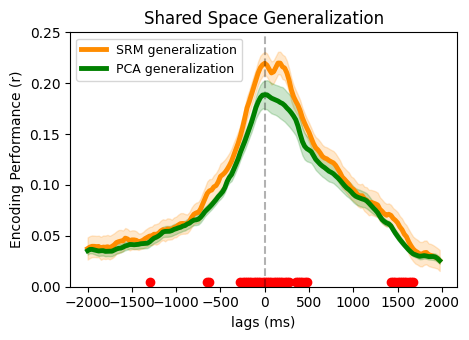

In [12]:
plt.figure(figsize=(4.8,3.5))

w=get_sig_lags1( lags, srm_shared_space_generalization[:,2,:],pca1, threshold=0.05)

plt.fill_between(lags, a[0,:], a[1,:], alpha=0.2, color='darkorange')
plt.plot(lags, a[2,:], linewidth=3.5, label = "SRM generalization", color='darkorange')  #, color=c1, ls=ls, lw = lw)
plt.axvline(0, ls="dashed", alpha=0.3, c="k")

plt.fill_between(lags, pca[0,:], pca[1,:], alpha=0.2, color='green')
plt.plot(lags, pca[2,:], linewidth=3.5, label = "PCA generalization", color='green')  #, color=c1, ls=ls, lw = lw)

plt.scatter(w, # (x)
                np.full(len(w), 0.005), # (y)
                color='red')

name_t='Shared Space Generalization'

plt.legend( prop={'size':9})
plt.xlabel('lags (ms)')
plt.ylabel('Encoding Performance (r)')
plt.title(name_t)
plt.ylim([0,0.25])
plt.tight_layout()

plt.savefig('/scratch/gpfs/arnab/Encoding/plot_mat_files/shared_space_generalization_new.png',dpi=600)

## Elctrode Space Generalization via SRM

In [ ]:
def srm_leave_one_out(Y_data, word,elec_num, train_index,test_index):

    X_train= word[train_index,:]
    X_test= word[test_index,:]
    # X1=np.tile(X_test,(len(subjects)-1,1))
    #X2=np.tile(X_train,(len(subjects)-1,1))
    #X1=X_test
    #X=np.concatenate((X_train, X2, ), axis=0)
    #X=np.concatenate((X_train, X1, ), axis=0)
    X=X_train
    X -= np.mean(X, axis=0)
    X_test2 =X_test- np.mean(X, axis=0)
    
    lag=np.shape(Y_data)[1]
    n_iter = 100
    
    # corr_with_742=[]
    # corr_with_798=[]
    final_corr=[]
    for i in range(lag):
        
        corr_with_subjects=[]
        
        for qq1 in range(len(subjects)):

            sub_now=subjects[qq1]
            train_data=[]
            test_data=[]
            subject_elec=elec_num[qq1]

            for qq in range(len(subjects)):
    
                if subjects[qq]!=sub_now:

                    data=Y_data[qq,i,:,:]
                    data=data[:,:elec_num[qq]]


                    train1=data[train_index,:].T
                    test1=data[test_index,:].T

                    train_data.append(train1)
                    test_data.append(test1)
                    
                else:
                    data=Y_data[qq,i,:,:]
                    data=data[:,:elec_num[qq]]


                    train1=data[train_index,:].T
                    test1=data[test_index,:].T

                    self_train=train1
                    self_test=test1

            srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=5)
            srm.fit(train_data)
            
            w_new=srm.transform_subject(self_train)
            #previous
            # q1=w_new.T.dot(self_train)
            # Y_train=(w_new.dot(q1)).T
            Y_train=(w_new.dot(srm.s_)).T
            
            q2=w_new.T.dot(self_test)
            Y_test=(w_new.dot(q2)).T
            # transform_test.append(srm1.w_[k].dot(q2))
            # transform_test.append(self_test)

            corr1_with_717=[]
            for k in range(subject_elec):
                
                
                Y=Y_train[:,k]

                #Y=np.concatenate((Y_train[:,k], Y_aug_train[:,k],), axis=0)
                #Y=np.concatenate((Y_train[:,k], Y_aug_test[:,k],), axis=0)
                
                Y -= np.mean(Y, axis=0)
                Y_test2 =Y_test[:,k]- np.mean(Y, axis=0)
                
                                
                clf_linear2=LinearRegression()
                clf_linear2.fit(X,Y)
                prediction_linear2=clf_linear2.predict(X_test2)
                corr1_with_717.append(np.corrcoef(Y_test2,prediction_linear2)[0,1])
                del clf_linear2
                
                
            corr_with_subjects.append(np.mean(corr1_with_717))

            #breakpoint()

            del Y_train
            del Y_test
            
        ww=np.array(corr_with_subjects)
            
        final_corr.append(ww)     
    

    return final_corr

In [ ]:
kf = KFold(n_splits=cv)
p=0
corr_leave_one_out=np.zeros((cv,len(lags),len(subjects)))

print('Computing Elec Space Generalization') 

for train_index, test_index in kf.split(word_embeddings):

    print('Fold:',p)
    
    corr_leave_one_out[p,:,:]=srm_leave_one_out(Y_data,word_embeddings,elec_num, train_index, test_index)

    p=p+1

In [13]:
filename2='/scratch/gpfs/arnab/Encoding/plot_mat_files/result_all_sub_compute_regression.mat'
lags=np.squeeze(loadmat(filename2)['lags'])
corr_original=np.squeeze(loadmat(filename2)['corr_original'])
original_regression=np.zeros((len(subjects),3,len(lags)))

filename17='/scratch/gpfs/arnab/Encoding/plot_mat_files/elec_space_generalization_across_subject.mat'
srm_leave_one_out1=np.squeeze(loadmat(filename17)['srm_leave_one_out'])
srm_leave_one_out=np.zeros((len(subjects),3,len(lags)))

In [14]:
for qq in range(len(subjects)):

    aa=corr_original[qq,:,:]    
    [a1,a2,mu]=plot_data_prep(aa)
    
    original_regression[qq,0,:]=a1
    original_regression[qq,1,:]=a2
    original_regression[qq,2,:]=mu
    
    del aa
    
    aa=srm_leave_one_out1[:,:,qq]
    [a1,a2,mu]=plot_data_prep(aa)
    
    srm_leave_one_out[qq,0,:]=a1
    srm_leave_one_out[qq,1,:]=a2
    srm_leave_one_out[qq,2,:]=mu

    del aa

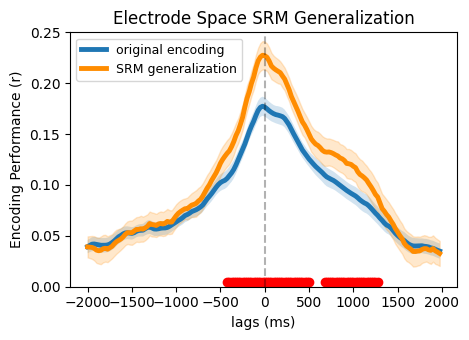

In [23]:
a3=np.mean(srm_leave_one_out,axis=0)
a2_original=np.mean(original_regression,axis=0)

plt.figure(figsize=(4.8,3.5))

w=get_sig_lags1( lags, srm_leave_one_out[:,2,:],original_regression[:,2,:], threshold=0.05)

plt.fill_between(lags, a2_original[0,:], a2_original[1,:], alpha=0.2)
plt.plot(lags, a2_original[2,:], linewidth=3.5, label = "original encoding")   #, color=c1, ls=ls, lw = lw)

plt.fill_between(lags, a3[0,:], a3[1,:], alpha=0.2, color='darkorange')
plt.plot(lags, a3[2,:], linewidth=3.5, label = "SRM generalization", color='darkorange')  #, color=c1, ls=ls, lw = lw)
plt.axvline(0, ls="dashed", alpha=0.3, c="k")

plt.scatter(w, # (x)
                np.full(len(w), 0.005), # (y)
                color='red')
name='Electrode Space SRM Generalization'

plt.legend( prop={'size':9})
plt.xlabel('lags (ms)')
plt.ylabel('Encoding Performance (r)')
plt.title(name)
plt.ylim([0,0.25])
plt.tight_layout()
plt.savefig('/scratch/gpfs/arnab/Encoding/elec_generalize.png',dpi=600)

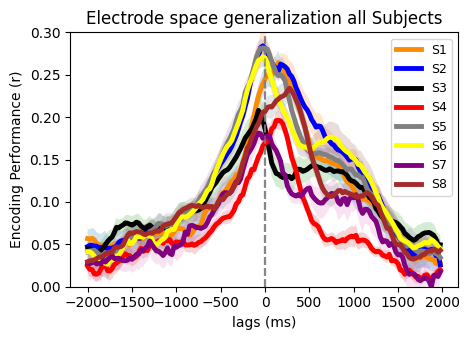

In [22]:
colors=['darkorange','b','k','r','grey','yellow','purple','brown']
plt.figure(figsize=(4.8,3.5))
for qq in range(len(subjects)):

    a1=srm_leave_one_out[qq,0,:]
    a2=srm_leave_one_out[qq,1,:]
    mu=srm_leave_one_out[qq,2,:]
    
    plt.fill_between(lags, a1, a2, alpha=0.2)
    # plt.plot(lags, mu, linewidth=3.5,label = 'Subject= %d' %(subjects[qq]),color=colors[qq],)  #, color=c1, ls=ls, lw = lw)
    plt.plot(lags, mu, linewidth=3.5,label = 'S'+str(qq+1),color=colors[qq],)  #, color=c1, ls=ls, lw = lw)

    plt.ylim([0,0.3])
    plt.xlabel('lags (ms)')
    plt.ylabel('Encoding Performance (r)')
    plt.title('Electrode space generalization all Subjects')
    plt.axvline(0, ls="dashed", alpha=0.3, c="grey")
    plt.legend( prop={'size':9})    
    plt.tight_layout()

plt.savefig('/scratch/gpfs/arnab/Encoding/elec_all_sub.png',dpi=600)

## Localizing Improvement across brain areas

In [ ]:
def srm_regression_all_elec(Y_data, word,elec_num, train_index,test_index):
    
    X_train= word[train_index,:]
    X_test= word[test_index,:]
    X1=np.tile(X_test,(len(subjects)-1,1))
    #X2=np.tile(X_train,(len(subjects)-1,1))
    #X1=X_test
    #X=np.concatenate((X_train, X2, ), axis=0)
    #X=np.concatenate((X_train, X1, ), axis=0)
    X=X_train
    X -= np.mean(X, axis=0)
    X_test2 =X_test- np.mean(X, axis=0)
    
    lag=np.shape(Y_data)[1]
    n_iter = 100
    
    # corr_with_742=[]
    # corr_with_798=[]
    final_corr=[]
    for i in range(lag):
        
        train_data=[]
        test_data=[]
        
        for qq in range(len(subjects)):
            
            data=Y_data[qq,i,:,:]
            data=data[:,:elec_num[qq]]
            
            
            train1=data[train_index,:].T
            test1=data[test_index,:].T
            
            train_data.append(train1)
            test_data.append(test1)
    
       
        
        srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=5)
        
        srm.fit(train_data)
        
        shared_test = srm.transform(test_data)
        shared_train = srm.transform(train_data)
        
                
        corr_with_subjects=[]
        
        for qq in range(len(subjects)):

            #print('subject:',subjects[qq])
            
            w0=srm.w_[qq]
            
            subject_elec=elec_num[qq]
            
            self_train=w0.dot(shared_train[qq])
            Y_train=self_train.T
            self_test=w0.dot(shared_test[qq])
            Y_test=self_test.T

            # Y_train=(train_data[qq]).T
            # Y_test=(test_data[qq]).T

            # ##breakpoint()

            # aa=np.arange(len(subjects))
            # aa=np.delete(aa,qq)
            
            # Y_aug_train=[]
            # Y_aug_test=[]
            
            # for index in aa:

            # #index=aa[5]
        
            #     #print(subjects[index])    
            #     signal_test=w0.dot(shared_test[index])
            #     signal_test=signal_test.T

            #     signal_train=w0.dot(shared_train[index])
            #     signal_train=signal_train.T

            #     Y_aug_train.append(signal_train)             
            #     Y_aug_test.append(signal_test)
            #     del signal_test
            #     del signal_train
                
            

            # Y_aug_train=np.array(Y_aug_train)
            # Y_aug_train=np.reshape(Y_aug_train,(np.shape(Y_aug_train)[0]*np.shape(Y_aug_train)[1],np.shape(Y_aug_train)[2]))
           
            # Y_aug_test=np.array(Y_aug_test)
            # Y_aug_test=np.reshape(Y_aug_test,(np.shape(Y_aug_test)[0]*np.shape(Y_aug_test)[1],np.shape(Y_aug_test)[2]))
            
            
            corr1_with_717=[]
            for k in range(subject_elec):
                
                
                Y=Y_train[:,k]

                #Y=np.concatenate((Y_train[:,k], Y_aug_train[:,k],), axis=0)
                #Y=np.concatenate((Y_train[:,k], Y_aug_test[:,k],), axis=0)
                
                Y -= np.mean(Y, axis=0)
                Y_test2 =Y_test[:,k]- np.mean(Y, axis=0)
                
                                
                clf_linear2=LinearRegression()
                clf_linear2.fit(X,Y)
                prediction_linear2=clf_linear2.predict(X_test2)
                corr1_with_717.append(np.corrcoef(Y_test2,prediction_linear2)[0,1])
                corr_with_subjects.append(np.corrcoef(Y_test2,prediction_linear2)[0,1])
                del clf_linear2
                
                
            # corr_with_subjects.append(corr1_with_717)

            #breakpoint()

            # del Y_aug_test
            # del Y_aug_train
            del Y_train
            del Y_test
            
        ww=np.array(corr_with_subjects)
        
        final_corr.append(ww)        
    return final_corr

In [ ]:
kf = KFold(n_splits=cv)
p=0
total_elec=sum([iterator for iterator  in elec_num])
corr_with_subjects1=np.zeros((cv,len(lags),total_elec))

print('Computing SRM All Elec')  

for train_index, test_index in kf.split(word_embeddings):

    print('Fold:',p)
    
    corr_with_subjects1[p,:,:]=srm_regression_all_elec(Y_data,word_embeddings,elec_num, train_index, test_index)

    p=p+1

corr_with_subjects_all_elec=corr_with_subjects1[0,:,:]
for ww in range(1,cv):
    corr_with_subjects_all_elec=corr_with_subjects_all_elec+corr_with_subjects1[ww,:,:]

corr_with_subjects_all_elec=corr_with_subjects_all_elec/cv

In [ ]:
def original_regression_all_elec(data1, word_embeddings,elec_num,cv):
    
    lag=np.shape(data1)[0]
    
    final_corr=np.zeros((cv,elec_num,lag))

    final_corr1=np.zeros((elec_num,lag))
    
    kf = KFold(n_splits=cv)
    p=0
    
    for train_index, test_index in kf.split(word_embeddings):
        
        corr_lin2=[]
        
        X_train,X_test = word_embeddings[train_index,:],word_embeddings[test_index,:]
    
        # X_train= word_embeddings[0:4000,:]  #working on the last fold
        # X_test= word_embeddings[4000:5013,:]
    
        X_train -= np.mean(X_train, axis=0)
        X_test -= np.mean(X_train, axis=0)
        
        for i in range(lag):
            
            corr_lin1=[]
            
            data=data1[i,:,:]
            data=data[:,:elec_num]
        
            for k in range(np.shape(data)[1]):
                
                label=data[:,k]  
                Y_train,Y_test = label[train_index],label[test_index]
                
                # Y_train=data[0:4000,k]  
                # Y_test=data[4000:5013,k]
                
                Y_train -= np.mean(Y_train, axis=0)
                Y_test -= np.mean(Y_train, axis=0)
              
                
                
                #We fit the Linear regression to our train set
                clf_linear=LinearRegression()
                clf_linear.fit(X_train,Y_train)
                
                
                prediction_linear=clf_linear.predict(X_test)
                
                corr_lin1.append(np.corrcoef(Y_test,prediction_linear)[0,1])
                
                del clf_linear
                
            corr_lin2.append(corr_lin1)
            
        final_corr[p,:,:]=np.asarray(corr_lin2).T
        p=p+1

    for w in range(cv):
        final_corr1=final_corr[w,:,:]+final_corr1
    final_corr1=final_corr1/cv



            
    return final_corr1, final_corr

In [ ]:
corr_original_all_elec1=[]

print('Computing Original Regression All Elec')
    
for qq in range(len(subjects)):
    
    final_corr1,final_corr=original_regression_all_elec(Y_data[qq,:,:,:], word_embeddings, elec_num[qq],cv)

    corr_original_all_elec1.append(final_corr1)
    # a=corr_original.append(original_regression_all_elec(Y_data[qq,:,:,:], word_embeddings, elec_num[qq],cv))
    
    if qq==0:
        corr_original_all_elec_cv=final_corr
    else:
        corr_original_all_elec_cv=np.concatenate((corr_original_all_elec_cv,final_corr),axis=1)


corr_original_all_elec=np.asarray(corr_original_all_elec1[0])
for qq in range(1,len(subjects)):
    corr_original_all_elec=np.concatenate((corr_original_all_elec,np.asarray(corr_original_all_elec1[qq])), axis=0)

In [28]:
filename15='/scratch/gpfs/arnab/Encoding/plot_mat_files/original_regression_all_elec.mat'
filename16='/scratch/gpfs/arnab/Encoding/plot_mat_files/srm_denoising_regression_all_elec.mat'

original_all_elec=np.squeeze(loadmat(filename15)['corr_original_all_elec'])
srm_all_elec=np.squeeze(loadmat(filename16)['srm_regression_all_elec']).T
lags=np.squeeze(loadmat(filename16)['lags'])



In [29]:
df_all_sub=pd.read_csv('/scratch/gpfs/arnab/Encoding/plot_mat_files/subject_info.csv')
subjects=np.unique(df_all_sub['subject'])


In [32]:
def plot_area(original_all_elec,srm_all_elec, index,name):
    
    original=original_all_elec[index,:]
    srm=srm_all_elec[index,:]
    
    w=get_sig_lags1( lags, srm,original)
    
    original_elec_area=np.zeros((3,len(lags)))
    srm_elec_area=np.zeros((3,len(lags)))
    
    [a1,a2,mu]=plot_data_prep(original)
    original_elec_area[0,:]=a1
    original_elec_area[1,:]=a2
    original_elec_area[2,:]=mu
    
    [a1,a2,mu]=plot_data_prep(srm)
    srm_elec_area[0,:]=a1
    srm_elec_area[1,:]=a2
    srm_elec_area[2,:]=mu
    
    plt.figure(figsize=(3.5, 2.7))
    
    plt.fill_between(lags, original_elec_area[0,:], original_elec_area[1,:], alpha=0.2)
    plt.plot(lags, original_elec_area[2,:], linewidth=3.5, label = "original")  #, color=c1, ls=ls, lw = lw)
    
    plt.fill_between(lags, srm_elec_area[0,:], srm_elec_area[1,:], alpha=0.2)
    plt.plot(lags, srm_elec_area[2,:], linewidth=3.5, label = "SRM")  #, color=c1, ls=ls, lw = lw)
    
    plt.scatter(w, # (x)
                    np.full(len(w), 0.001), # (y)
                    color='red')

    plt.axvline(0, ls="dashed", alpha=0.3, c="grey")
    plt.legend()
    plt.xlabel('lags (ms)')
    plt.ylabel('Correlation')
    plt.title(name)
    plt.ylim([0,0.4])
    plt.tight_layout()
    plt.savefig('/scratch/gpfs/arnab/Encoding/aSTG.png',dpi=600)

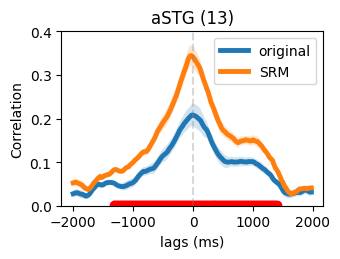

In [33]:
# area wise plotting
# brain_areas=['IFG','STG','TP','AG',]
# sub_areas=['aSTG','cSTG','mSTG']

brain_areas=['STG']
sub_areas=['aSTG']


for area in brain_areas:
    
    if area=='STG':

        for sub_area in sub_areas:

            index=np.squeeze(np.where(df_all_sub['area3']==sub_area))

            name=sub_area+' '+'('+str(len(index))+')'

            if len(index)>0:
                plot_area(original_all_elec,srm_all_elec, index,name)

    elif area=='right':

        for sub_area in brain_areas:

            index=np.squeeze(np.where(df_all_sub['area2']==sub_area))

            name='Right_'+sub_area+' '+'('+str(len(index))+')'

            if len(index)>0:
                plot_area(original_all_elec,srm_all_elec, index,name)
    
    else:
    
        index=np.squeeze(np.where(df_all_sub['area']==area))
        name=area+' '+'('+str(len(index))+')'
        if len(index)>0:
            plot_area(original_all_elec,srm_all_elec, index,name)

    # index=np.squeeze(np.where(df_all_sub['area2']==area2))
    
    

## Quantifying Shared Information across Subjects

In [29]:
index=np.where(np.asarray(lags)==0) #taking the ECoG data for lag 0
lags=[0]
Y_data1=Y_data[:,index,:,:]
Y_data1=np.squeeze(Y_data1, axis=1)
np.shape(Y_data1)

(8, 1, 5013, 43)

In [ ]:
def srm_leave_one_out(Y_data,elec_num, train_index,test_index):

    lag=np.shape(Y_data)[1]
    n_iter = 20
    
    # corr_with_742=[]
    # corr_with_798=[]
    final_corr=[]
#     final_std=[]
    for i in range(lag):
        
        corr_with_subjects=[]
        
        for qq1 in range(len(subjects)):

            sub_now=subjects[qq1]
            # print(sub_now)
            train_data=[]
            test_data=[]
            subject_elec=elec_num[qq1]

            for qq in range(len(subjects)):
    
                if subjects[qq]!=sub_now:

                    data=Y_data[qq,i,:,:]
                    data=data[:,:elec_num[qq]]


                    train1=data[train_index,:].T
                    test1=data[test_index,:].T

                    train_data.append(train1)
                    test_data.append(test1)
                    
                else:
                    data=Y_data[qq,i,:,:]
                    data=data[:,:elec_num[qq]]


                    train1=data[train_index,:].T
                    test1=data[test_index,:].T

                    self_train=train1
                    self_test=test1

            srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=5)
            srm.fit(train_data)
            
            # transform_train=[]
            # transform_test=[]
            
            shared_test_srm= srm.transform(test_data)
            
            w_new=srm.transform_subject(self_train)
            q1=w_new.T.dot(self_train)
            Y_train=(w_new.dot(q1)).T
            # transform_train=(converted_train1[k])
            # transform_train.append(train_data[k])
            
            s_test=shared_test_srm[0]
            for kk in range(1,len(subjects)-1):

                s_test=s_test+shared_test_srm[kk]
                
            s_test=s_test/(len(subjects)-1)
            
            reconstructed_data=w_new.dot(s_test)
            
#             print(np.shape(reconstructed_data))
#             print(np.shape(self_test))
            
            corr=[]
            for elec in range(np.shape(reconstructed_data)[0]):
                
                corr.append(np.corrcoef(reconstructed_data[elec,:],self_test[elec,:])[0,1])
                
            final_corr.append(np.mean(corr))
#             final_std.append(np.std(corr)/sqrt(np.shape(reconstructed_data)[0]))
            
            
            
#         ww=np.array(corr_with_subjects)
            
#         final_corr.append(ww)     
        
    

    return final_corr

In [ ]:
kf = KFold(n_splits=cv)
p=0
corr_leave_one_out=np.zeros((cv,len(lags),len(subjects)))
corr_std=np.zeros((cv,len(lags),len(subjects)))

for train_index, test_index in kf.split(word_embeddings):

        # print('Fold:',p)
        
        corr_leave_one_out[p,:,:]=srm_leave_one_out(Y_data1,elec_num, train_index, test_index)
        
        
    
        p=p+1
        
a11=np.asarray(corr_leave_one_out[:,0,:])
a=np.mean(a11,axis=0)

b=np.std(a11,axis=0)/np.sqrt(cv)

print(a)
print(b)